# Momento de Retroalimentación:
## Módulo 2 Implementación de un modelo de deep learning.

Antonio Oviedo Paredes A01752114

## 1. Introducción

###  Desarrollo de un modelo de Red Neuronal Convolucional para el reconocimiento de imágenes en lenguaje de señas

La comunicación es una parte fundamental de la vida humana, y el lenguaje de señas desempeña un papel crucial en facilitar la interacción para aquellas personas con discapacidades auditivas. Aunque el lenguaje de señas es un medio efectivo de expresión, su comprensión por parte de sistemas basados en inteligencia artificial plantea un desafío significativo. Este notebook aborda específicamente el problema del reconocimiento de imágenes en lenguaje de señas de números mediante la aplicación de modelos de Redes Neuronales Convolucionales.

El reconocimiento preciso de gestos y señas en imágenes de lenguaje de señas es una tarea compleja debido a la variabilidad inherente en la posición de las manos, la velocidad del gesto y la presencia de gestos simultáneos. La falta de herramientas efectivas para traducir estos gestos crea barreras en la comunicación para la comunidad de personas con discapacidad auditiva. Este notebook propone abordar este problema desarrollando un modelo de CNN capaz de reconocer con precisión los signos de algunas señas en imágenes estáticas.

La importancia de superar las barreras en la comunicación para las personas con discapacidad auditiva no puede subestimarse. El desarrollo de un sistema preciso y eficiente para el reconocimiento de imágenes en lenguaje de señas tiene implicaciones directas en la mejora de la calidad de vida de esta comunidad, facilitando su participación en diversos entornos sociales y profesionales. Además, este trabajo demuestra cómo las tecnologías emergentes pueden tener un impacto positivo y significativo en la inclusión y accesibilidad.

## 2. Datos

### 2.1 Descarga de los datos

In [ ]:
# !mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                    title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                        DAIGT V2 Train Dataset                           29MB  2023-11-16 01:38:36           1067        117  1.0              
muhammadbinimran/housing-price-prediction-data         Housing Price Prediction Data                   763KB  2023-11-21 17:56:32           3909         78  1.0              
carlmcbrideellis/llm-7-prompt-training-dataset         LLM: 7 prompt training dataset                   41MB  2023-11-15 07:32:56           1397        108  1.0              
maso0dahmed/video-games-data                           Video Games Data                                  5MB  2023-11-25 19:0

In [ ]:
!kaggle datasets download -d maneesh99/signs-detection-dataset

 56% 5.00M/8.88M [00:00<00:00, 31.9MB/s]
100% 8.88M/8.88M [00:00<00:00, 52.6MB/s]


In [ ]:
!unzip signs-detection-dataset.zip

Archive:  signs-detection-dataset.zip
  inflating: Signs_Data_Testing.h5   
  inflating: Signs_Data_Training.h5  


In [ ]:
import h5py

train_data = h5py.File('Signs_Data_Training.h5')
test_data = h5py.File('Signs_Data_Testing.h5')

### 2.2 Preparación de los datos


In [ ]:
import pandas as pd
import numpy as np

# Extract training and testing data from the dataset
X_train = np.array(train_data['train_set_x'])
y_train = np.array(train_data['train_set_y'])
X_test = np.array(test_data['test_set_x'])
y_test = np.array(test_data['test_set_y'])

# Reshape the input data to the correct form
X_train = X_train.reshape(1080, -1)
X_train = pd.DataFrame(X_train)

X_test = X_test.reshape(120, -1)
X_test = pd.DataFrame(X_test)

# Create DataFrames for training and testing labels
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# Rename the label columns
y_train.columns = ['Label']
y_test.columns = ['Label']

# Reshape the input data to the shape of 64x64x3 images
X_train = X_train.values.reshape(1080, 64, 64, 3)
X_test = X_test.values.reshape(120, 64, 64, 3)

# Dimensions
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((1080, 64, 64, 3), (1080, 1), (120, 64, 64, 3), (120, 1))

(64, 64, 3)
Class:  Label    5
Name: 29, dtype: int64


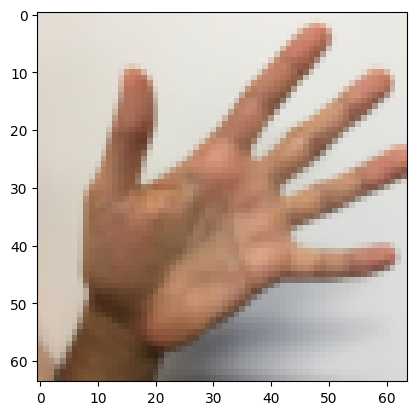

In [ ]:
import matplotlib.pyplot as plt

# Display image
pi = 29
plt.imshow(X_train[pi])
print(X_train[pi].shape)
print("Class: ", y_train.iloc[pi])


In [ ]:
# One hot encode output
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

## 3. Modelo


### 3.1 Arquitectura del modelo inicial

Capas convolucionales y max pooling: La secuencia de capas convolucionales y max pooling se utiliza para extraer características relevantes de las imágenes de señas. Las capas de max pooling ayudan a reducir la dimensionalidad y a focalizarse en las características más importantes, lo que contribuye a mejorar la eficiencia computacional y a prevenir el overfitting.

Número creciente de filtros: La progresión en el número de filtros (16, 32, 64, 128) en las capas convolucionales refleja una jerarquía de complejidad creciente. Las capas iniciales pueden aprender menos características simples, como bordes y colores, mientras que las capas posteriores pueden capturar un mayor número de patrones más complejos y abstractos.

Capas fully connected con dropout: Después de extraer características relevantes con las capas convolucionales, se utilizan capas totalmente conectadas para realizar la clasificación final. La inclusión de capas de dropout ayuda a prevenir el overfitting al desactivar aleatoriamente un porcentaje de neuronas durante el entrenamiento.

Capa de salida softmax: La capa de salida con función de activación softmax es apropiada para problemas de clasificación multiclase. En este caso, se asume que hay seis clases correspondientes a las señas del 0 al 5.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Define a sequential model
model = Sequential([
    Input(shape=[64, 64, 3]),
    Conv2D(filters=16, kernel_size=5, activation="relu"),
    MaxPooling2D(2),
    Conv2D(filters=32, kernel_size=5, activation="relu"),
    MaxPooling2D(2),
    Conv2D(filters=64, kernel_size=4, activation="relu"),
    MaxPooling2D(2),
    Conv2D(filters=128, kernel_size=3, activation="relu"),
    MaxPooling2D(2),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(6, activation="softmax")
])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        32832     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 64)          0

### 3.2 Entrenamiento del modelo

In [ ]:
# Adam optimizer with a 0.0001 learning rate
opt = keras.optimizers.Adam(learning_rate=.0001)
# Sparse Categorical Accuracy metric
acc = keras.metrics.SparseCategoricalAccuracy()
# Mean Absolute Error metric
mae = keras.metrics.MeanAbsoluteError()

# Compile the model with the specified optimizer, loss function, and metrics
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=[acc, mae])

# Train the model on the training data with validation split, using 30 epochs
history = model.fit(X_train, y_train, validation_split=0.1, epochs=30)

Epoch 1/30
31/31 [==============================] - 13s 29ms/step - loss: 13.2521 - sparse_categorical_accuracy: 0.1667 - mean_absolute_error: 2.3666 - val_loss: 1.8423 - val_sparse_categorical_accuracy: 0.2130 - val_mean_absolute_error: 2.5895
Epoch 2/30
31/31 [==============================] - 0s 11ms/step - loss: 3.2740 - sparse_categorical_accuracy: 0.1811 - mean_absolute_error: 2.3666 - val_loss: 1.7554 - val_sparse_categorical_accuracy: 0.2500 - val_mean_absolute_error: 2.5895
Epoch 3/30
31/31 [==============================] - 0s 10ms/step - loss: 2.3835 - sparse_categorical_accuracy: 0.1924 - mean_absolute_error: 2.3666 - val_loss: 1.7621 - val_sparse_categorical_accuracy: 0.2037 - val_mean_absolute_error: 2.5895
Epoch 4/30
31/31 [==============================] - 0s 10ms/step - loss: 2.2143 - sparse_categorical_accuracy: 0.1821 - mean_absolute_error: 2.3666 - val_loss: 1.7579 - val_sparse_categorical_accuracy: 0.2778 - val_mean_absolute_error: 2.5895
Epoch 5/30
31/31 [========

### 3.3 Análisis del modelo

El rendimiento del modelo presentado, con una precisión de clasificación baja, sugiere que la arquitectura actual podría ser muy simple para el conjunto de datos de imágenes de señas del 1 al 5 proporcionado. La baja precisión indica dificultades en la clasificación de las señas en el conjunto de prueba, y las diferencia entre la precisión de entrenamiento y validación sugiere un posible subajuste del modelo.

Una de las posibles causas de este problema podría ser que la arquitecura no es lo suficiente compleja, lo que podría llevar al modelo a no poder aprender los patrones de las manos. Para abordar esto, se podría considerar aumentar la complejidad del modelo, agregando capas o modificando las existentes.

En resumen, se sugiere realizar ajustes en la arquitectura tomando en cuenta no caer en sobreajuste.

<Axes: title={'center': 'Loss vs Epoch'}>

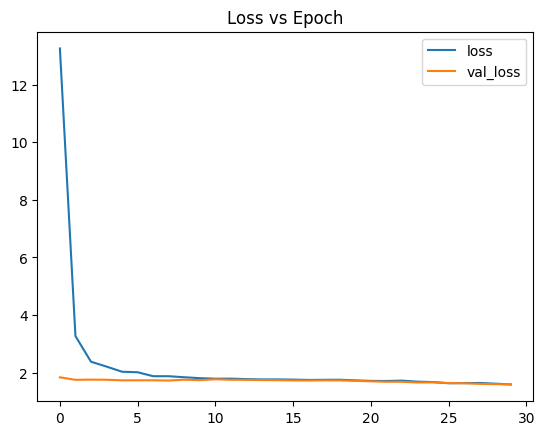

In [ ]:
# Create a DataFrame from the training history
df = pd.DataFrame(history.history)

# Training loss and validation loss over epochs
df.plot(y=["loss", "val_loss"], title="Loss vs Epoch")


<Axes: title={'center': 'Sparse Categorical Accuracy vs Epoch'}>

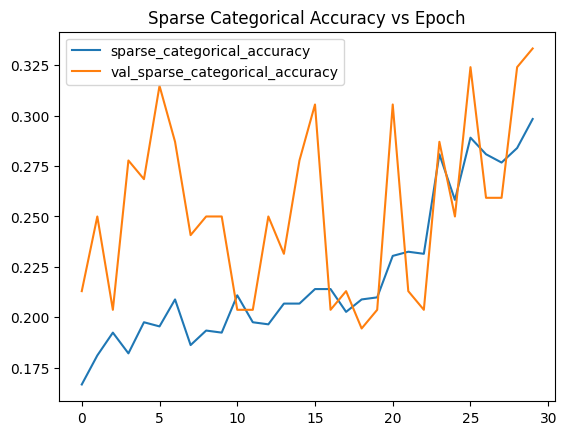

In [ ]:
# Training sparse categorical accuracy and validation sparse categorical accuracy over epochs
df.plot(y=["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"], title="Sparse Categorical Accuracy vs Epoch")

In [ ]:
loss, accuracy, mae = model.evaluate(X_test, y_test)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"MAE: {mae:.2f}")

4/4 [==============================] - 0s 40ms/step - loss: 1.5422 - sparse_categorical_accuracy: 0.3500 - mean_absolute_error: 2.3889
Loss: 1.54
Accuracy: 0.35
MAE: 2.39


## 4. Ajuste del modelo

### 4.1 arquitectura mejorada del modelo

Se redujo el número de capas convolucionales de cuatro a tres, con filtros ajustados a 32, 64 y 128 en sucesión. Este cambio tiene la intención de simplificar la arquitectura para adaptarse mejor al conjunto de datos de imágenes de señas, mitigando posibles problemas de overfitting asociados con la complejidad inicial.

Adicionalmente, se ha eliminado una capa fully connected. Este ajuste busca evitar complejidades innecesarias que podrían conducir al overfitting. La tasa de dropout se ha mantenido en 0.5 para contrarrestar cualquier indicio de overfitting que pueda surgir durante el entrenamiento.

Por otra parte se redujo el número de epocas ya que se observó que a partir de la epaca 15 el modelo comenzaba a presentar overfitting.

En resumen, estas adaptaciones buscan equilibrar la complejidad del modelo para mejorar su capacidad de generalización, manteniendo al mismo tiempo la efectividad en la clasificación de señas. La experimentación iterativa sigue siendo fundamental para ajustar la arquitectura y optimizar el rendimiento del modelo en la tarea específica de reconocimiento de señas.

Cambios al modelo:
1. Batch Normalization: Se ncluyeron capas de normalización después de algunas capas convolucionales y totalmente conectadas. Esta técnica ayuda a estabilizar y acelerar el entrenamiento.
2. Dropout: El primer modelo utiliza la técnica de dropout después de capas densas para mitigar el sobreajuste. Se aplica una tasa de dropout del 50% en varias capas. Por otro lado el segundo modelo también utiliza dropout, pero con tasas de dropout ajustadas individualmente para cada capa, lo que permite un control más fino de la regularización.
3. Tamaño de Kernel: El segundo modelo tiliza un tamaño de kernel de 4 en todas las capas convolucionales, mientras que el primer modelo varía los tamaños de kernel.
4. Capas totalmente conectadas: Se eliminó la última capa de 64 entradas.


La introducción de Batch Normalization, ajuste fino de tasas de dropout, y el uso consistente de técnicas de regularización en el segundo modelo buscan mejorar la capacidad de generalización del modelo y reducir el riesgo de sobreajuste y subajuste. Estos ajustes permiten un control más preciso sobre la regularización en diferentes capas, mejorando así la capacidad del modelo para aprender patrones relevantes en los datos de entrenamiento sin memorizarlos.

In [ ]:
better_model = Sequential([
    Input(shape=(64, 64, 3)),
    Conv2D(filters=64, kernel_size=4, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(0.2),

    Conv2D(filters=128, kernel_size=4, activation='relu'),
    MaxPooling2D(2),
    Dropout(0.3),

    Conv2D(filters=256, kernel_size=4, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(6, activation='softmax')

])

better_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        3136      
                                                                 
 batch_normalization_8 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 30, 30, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 128)       131200    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 13, 13, 128)      

### 4.2 Entrenamiento del modelo mejorado

Diferencias en el entrenamiento:

1. Early Stopping:

Primer modelo: No utiliza ningún mecanismo de parada anticipada.

Segundo modelo: Implementa EarlyStopping con 'val_sparse_categorical_accuracy', deteniendo el entrenamiento si no mejora durante 10 épocas y restaurando los pesos del modelo con el mejor rendimiento en la métrica de validación.

2. Número de Épocas:

Primer modelo: Entrenamiento durante 30 épocas.

Segundo modelo: Entrenamiento durante hasta 100 épocas, pero con la posibilidad de detenerse antes gracias a la parada anticipada.
Batch Size:

3. Batch size:

Primer modelo: No especifica un tamaño de lote (batch size), por lo que utiliza el tamaño predeterminado.

Segundo modelo: Utiliza un tamaño de lote de 32 durante el entrenamiento.


In [ ]:
# Adam optimizer with a 0.0001 learning rate
b_opt = keras.optimizers.Adam(learning_rate=.0001)
# Sparse Categorical Accuracy metric
b_acc = keras.metrics.SparseCategoricalAccuracy()
# Mean Absolute Error metric
b_mae = keras.metrics.MeanAbsoluteError()

# Compile the model with the specified optimizer, loss function, and metrics
better_model.compile(optimizer=b_opt, loss='sparse_categorical_crossentropy', metrics=[b_acc, b_mae])

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, restore_best_weights=True)

# Train the model on the training data with validation split, using 15 epochs
b_history = better_model.fit(X_train, y_train, validation_split=0.1, epochs=100, callbacks=[early_stopping], batch_size=32)


Epoch 1/100
31/31 [==============================] - 4s 32ms/step - loss: 2.6499 - sparse_categorical_accuracy: 0.2047 - mean_absolute_error: 2.3666 - val_loss: 2.6228 - val_sparse_categorical_accuracy: 0.2037 - val_mean_absolute_error: 2.5895
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: 2.1333 - sparse_categorical_accuracy: 0.3148 - mean_absolute_error: 2.3666 - val_loss: 1.9083 - val_sparse_categorical_accuracy: 0.2407 - val_mean_absolute_error: 2.5895
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 1.8921 - sparse_categorical_accuracy: 0.3683 - mean_absolute_error: 2.3666 - val_loss: 1.6892 - val_sparse_categorical_accuracy: 0.2315 - val_mean_absolute_error: 2.5895
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 1.6398 - sparse_categorical_accuracy: 0.4228 - mean_absolute_error: 2.3666 - val_loss: 1.5659 - val_sparse_categorical_accuracy: 0.2778 - val_mean_absolute_error: 2.5895
Epoch 5/100
31/31 [=====

### 4.3 Análisis del modelo mejorado

<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

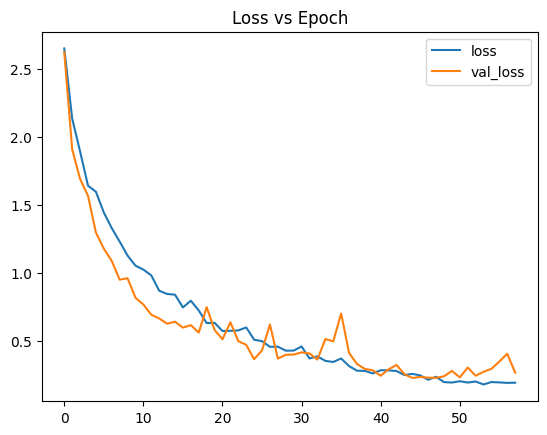

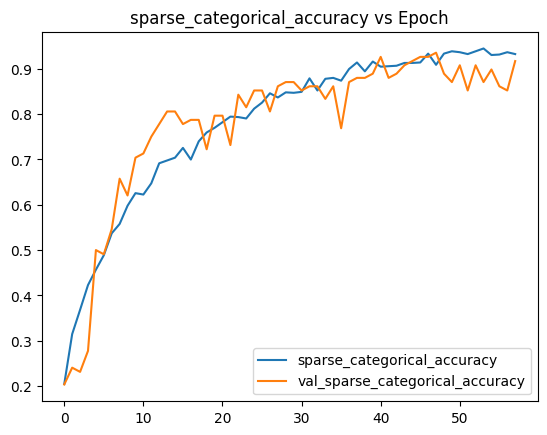

In [ ]:
# Create a DataFrame from the training history
b_df = pd.DataFrame(b_history.history)

# Training loss and validation loss over epochs
b_df.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

# Training sparse categorical accuracy and validation sparse categorical accuracy over epochs
b_df.plot(y=["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"], title="sparse_categorical_accuracy vs Epoch")

## 5. Resultados


### 5.1 Métricas del modelo

El primer modelo, mostro subajuste, con una precisión de solo 0.35 en el conjunto de prueba. Estos resultados indicaban dificultades para generalizar patrones a nuevas instancias de señas y sugerían que la complejidad del modelo debería de incrementar para el conjunto de datos proporcionado.

El modelo se hizo más complejo y los resultados indican una mejora sustancial en el rendimiento. La matriz de confusión muestra una clasificación precisa de las seis clases de señas, con una precisión global del 92%. El loss ha disminuido considerablemente a 0.25, indicando una mejor capacidad del modelo para ajustarse a los datos de entrenamiento.

El análisis del informe de clasificación revela que el modelo es capaz de reconocer todas las clases con buena precisión, destacando la mejora en la capacidad de generalización. La precisión, recall y f1-score se encuentran en niveles aceptables para todas las clases, indicando una mejora generalizada en la capacidad del modelo para clasificar señas. Este rendimiento sugiere que la modificación en la arquitectura del modelo han resultado en beneficios tangibles, mejorando la capacidad de generalización y, por ende, la precisión en la tarea de reconocimiento de señas.

4/4 [==============================] - 0s 5ms/step


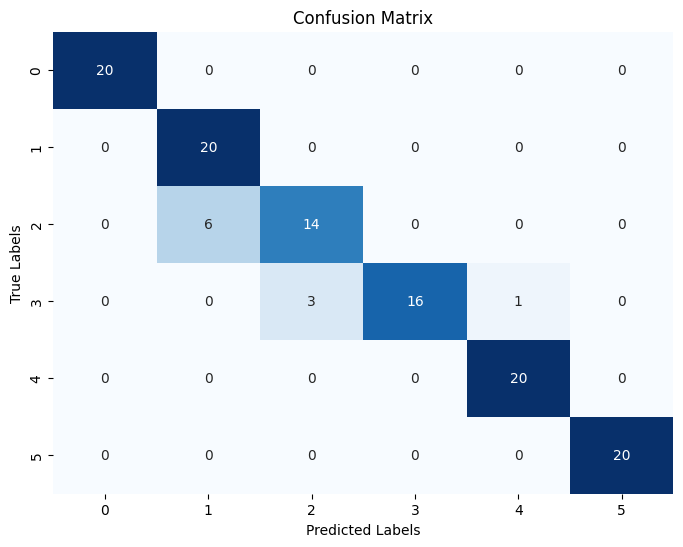


Loss: 0.25
Accuracy: 0.92
MAE: 2.39

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.77      1.00      0.87        20
           2       0.82      0.70      0.76        20
           3       1.00      0.80      0.89        20
           4       0.95      1.00      0.98        20
           5       1.00      1.00      1.00        20

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.92      0.92       120


Overall Accuracy: 0.92


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Evaluate the model
b_loss, b_accuracy, b_mae = better_model.evaluate(X_test, y_test)

# Model predictions on the test set
y_pred = better_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print additional metrics
print()
print(f"Loss: {b_loss:.2f}")
print(f"Accuracy: {b_accuracy:.2f}")
print(f"MAE: {b_mae:.2f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Print overall accuracy
print(f"\nOverall Accuracy: {accuracy_score(y_test, y_pred_classes):.2f}")


### 5.2 Predicciones del modelo



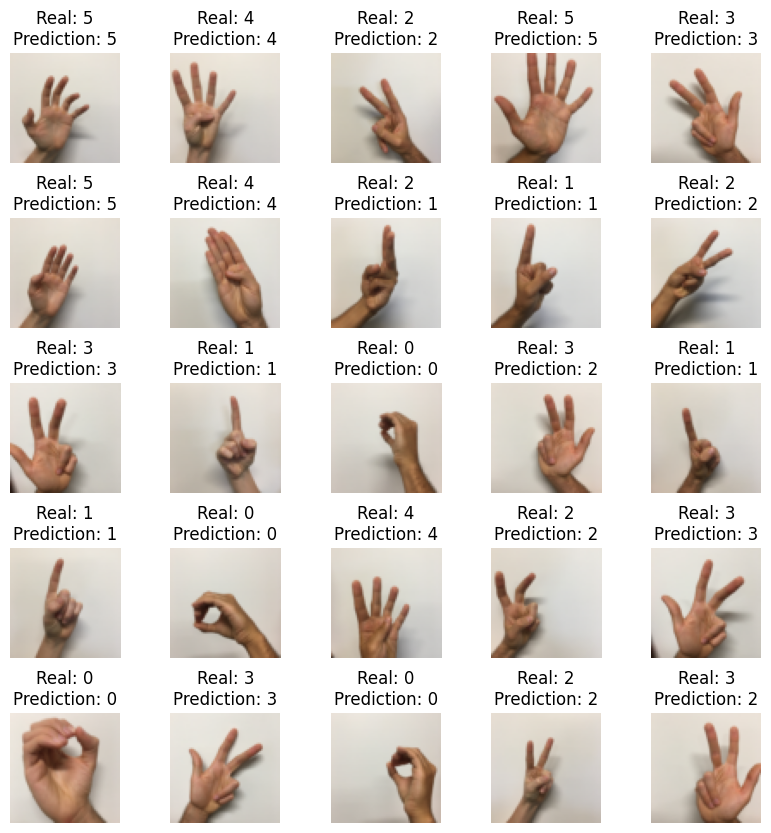

In [ ]:
set_b = 20

# Create a figure and axes using subplots
cols = 5
rows = 5
fig, axs = plt.subplots(rows, cols, figsize=(10, 10), gridspec_kw={'hspace': 0.5})

# Iterate through the image paths and display them in the grid
for i in range(cols * rows):
  row = i // cols
  col = i % cols
  axs[row, col].imshow(X_test[i + set_b])
  axs[row, col].set_title(f'Real: {y_test.iloc[i + set_b]["Label"]}\nPrediction: {np.argmax(y_pred[i + set_b])}')
  axs[row, col].axis('off')

plt.show()


### 5.2 Predicciones del modelo con imágenes propias


In [ ]:
from matplotlib.image import imread

def predict_sign(folder):
  # Get image paths
  imgs_p = [folder + p for p in os.listdir(folder) if p.split(".")[-1] == "jpg"]

  # Images to np array
  imgs = np.array([imread(image_path) for image_path in imgs_p])

  y_new_pred = better_model.predict(imgs, verbose = 0)

  sign_class = np.argmax(y_new_pred, axis=1)

  return imgs, sign_class


Para evaluar la robustez y el rendimiento del modelo en condiciones diversas, se llevaron a cabo pruebas utilizando nuevas imágenes tomadas en distintos entornos y condiciones de iluminación. Este conjunto de datos variado se diseñó para desafiar al modelo, exponiéndolo a escenarios no vistos durante el entrenamiento. Los resultados revelaron que la gran mayoría de las imágenes fueron clasificadas correctamente, evidenciando la capacidad del modelo para generalizar efectivamente a través de variaciones en entornos y luminosidad. Los errores de clasificación que se observaron se atribuyeron principalmente a las diferencias sutiles entre las imágenes de prueba y las utilizadas en la fase de entrenamiento.

Enter the path of the folder containing the test images: ./fotos/


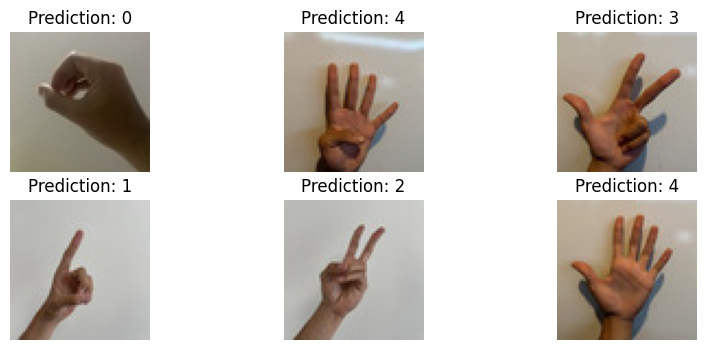

In [ ]:
import os

folder = input("Enter the path of the folder containing the test images: ")

# Predict from images in folder
imgs, preds = predict_sign(folder)

# Create a figure and axes using subplots
cols = 3
rows = 2
fig, axs = plt.subplots(rows, cols, figsize=(10, 4), gridspec_kw={'hspace': 0.2})

# Iterate through the image paths and display them in the grid
for i in range(preds.shape[0]):
  row = i // cols
  col = i % cols
  axs[row, col].imshow(imgs[i])
  axs[row, col].set_title(f'Prediction: {preds[i]}')
  axs[row, col].axis('off')

plt.show()

## 6. Conclusiones

En conclusión, al abordar el desafío del reconocimiento de imágenes de lenguaje de señas mediante modelos de inteligencia artificial, se evidenció la importancia de encontrar un equilibrio entre la complejidad del modelo y la capacidad de generalización. El primer modelo, con una arquitectura más compleja, mostró signos de subajuste y un rendimiento limitado en la tarea de clasificación de señas.

Con el objetivo de mejorar estos resultados, se propuso un segundo modelo caracterizado por una arquitectura más compleja. Este ajuste condujo a una mejora significativa, evidenciada por una matriz de confusión precisa y métricas de evaluación aceptables para todas las clases de señas. La precisión global alcanzó 92% de precisión, indicando una mayor capacidad de generalización y confianza en la clasificación de señas.

En resumen, la adaptación y simplificación de la arquitectura del modelo resultaron en beneficios, demostrando que la efectividad en tareas específicas como el reconocimiento de señas puede mejorar significativamente al encontrar un equilibrio adecuado en la complejidad del modelo.